### Fiona Fan
Problem 1

In [31]:
import numpy as np
from scipy import linalg as la
import cmath

In [32]:

def QR(A):
    (m,n) = A.shape
    
    Q=np.copy(A)
    
    R=np.zeros((n,n))
    
    for i in range (n):
        R[i,i]=la.norm(Q[:,i])
        Q[:,i]=Q[:,i]/R[i,i]
        for j in range (i+1,n):
            R[i,j]=np.dot(np.transpose(Q[:,j]),Q[:,i])
            Q[:,j]=Q[:,j]-R[i,j]*Q[:,i]
    
    return Q,R

In [33]:
A=np.random.random((6,4))
Q,R=QR(A)
print(A.shape,Q.shape,R.shape)

(6, 4) (6, 4) (4, 4)


In [34]:
Q1,R1=la.qr(A,mode="economic")
print(A.shape,Q1.shape,R1.shape)

(6, 4) (6, 4) (4, 4)


In [35]:
np.allclose(np.triu(R),R)

True

In [36]:
np.allclose(Q.T@Q, np.identity(4))

True

In [37]:
np.allclose(Q@R,A)

True

Problem 2

In [38]:
def getDet(A):
    m,n = A.shape
    if m!=n:
        print("A is not a squre.")
        return
    
    Q1, R1 = QR(A)
    det = 1
    for i in range(n):
        det *= R1[i,i]
    return det

In [39]:
B = np.random.random((5,5))
true_det = la.det(B)
my_det = getDet(B)
print("Error: ", true_det - my_det)

Error:  -0.09531412575159198


Problem 3

In [40]:
def solveLinearSystem(A, b):
    #A is a n*n linear matrix, invertible b is n*1
    if abs(la.det(A))<1e-6:
        print("A is not invertible")
        return
    Q1, R1 = QR(A)
    y = np.dot(np.transpose(Q1), b)
    m, n = A.shape
    x = np.empty(n)
    for i in range(n-1, -1, -1):
        x[i] = y[i] / R1[i,i]
        #update y
        for j in range(n):
            y[j] = y[j] - R1[j,i]*x[i]
        
    return x

In [41]:
A2 = np.random.random((5,5))
#add diagonals to make it invertible
A2 = A2 + 100*np.eye(5)
b2 = np.array([1,2,3,4,5])
print(np.dot(A2, solveLinearSystem(A2, b2)))


[1. 2. 3. 4. 5.]


Problem 4

In [42]:
def householder(A):
    #A should be a matrix of m*n and has rank n
    sign = lambda x : 1 if x>= 0 else -1
    
    m, n = A.shape
    R = np.copy(A)
    Q = np.eye(m)
    for k in range(n):
        u = np.copy(R[k:, k])
        u[0] = u[0] + sign(u[0])*la.norm(u)
        u = u / la.norm(u)
        R[k:, k:] = R[k:, k:] - 2 * np.outer(u, np.matmul(np.transpose(u), R[k:, k:]))
        Q[k:, :] = Q[k:, :] - 2 * np.outer(u, np.matmul(np.transpose(u), Q[k:, :]))
    return np.transpose(Q), R

In [43]:
A = np.random.random((5,3))
Q, R = la.qr(A)
print(A.shape, Q.shape, R.shape)

(5, 3) (5, 5) (5, 3)


In [44]:
my_Q, my_R = householder(A)
np.allclose(my_Q@my_R, A)

True

In [45]:
np.allclose(my_Q, Q)

True

In [46]:
np.allclose(my_R, R)

True

Problem 5

In [47]:
def hess(A):
    sign = lambda x : 1 if x>= 0 else -1
    
    #A is an invertible n*n matrix
    m, n = A.shape
    H = np.copy(A)
    Q = np.eye(m)
    for k in range(n-2):
        u = np.copy(H[k+1:, k])
        u[0] += sign(u[0]) * la.norm(u)
        u = u / la.norm(u)
        
        H[k+1: ,k:] -= 2 * np.outer(u, np.matmul(u, H[k+1:, k:]))
        H[:, k+1:] = H[:, k+1:] - 2 * np.outer(np.dot(H[:, k+1:], u), u.T)
        Q[k+1:, :] -= 2 * np.outer(u, np.matmul(np.transpose(u),Q[k+1:, :]))

    return H, np.transpose(Q)

A5 = np.random.random((8,8))
#add diagonals to make it invertible
A5 += 5*np.eye(8)
H, Q = la.hessenberg(A5, calc_q = True)
my_H, my_Q = hess(A5)


In [48]:
np.allclose(my_H, H)

True

In [49]:
np.allclose(my_Q, Q)

True

Part 2 

Problem 1 

In [50]:
def leastsqbyQR(A, b):
    #A is a m*n matrix, b is n*1 vector
    Q, R = la.qr(A, mode = "economic")
    #the linear system then becomes R \hat{x} = Q.T b
    #print(R)
    
    y = np.dot(np.transpose(Q), b)
    m, n = A.shape
    x_hat = np.empty(n)
    for i in range(n-1, -1, -1):
        x_hat[i] = y[i] / R[i,i]
        #update y
        for j in range(n):
            y[j] = y[j] - R[j,i]*x_hat[i]
        
    return x_hat

In [51]:
Als = np.array([[-1,1], [0, 1], [1, 1], [2,1]])
bls = np.array([0 ,1 ,2,1])
leastsqbyQR(Als, bls)

array([0.4, 0.8])

Problem 2

In [52]:
import matplotlib.pyplot as plt
def fitLine():
    data = np.load("housing.npy")
    years = data[:, 0]
    prices = data[:, 1]
    
    constants = np.ones(len(years))
    A = np.column_stack((years, constants))
    coeff = leastsqbyQR(A, prices)
    print("Slope: ", coeff[0], "Intercept: ", coeff[1])
    plt.plot(years, prices, "o", markersize = 4)
    plt.xlabel("Year")
    plt.ylabel("Price Index")
    plt.title("Regression Line of Price Index with Year")
    plt.plot(np.arange(18), coeff[0]*np.arange(18)+coeff[1])
    plt.show()
    
    
    

Slope:  3.3747660427807404 Intercept:  164.080962566845


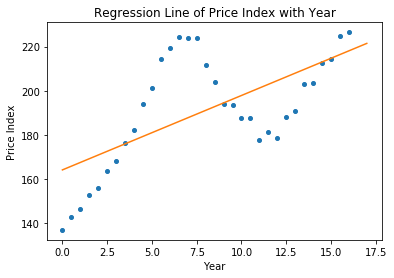

In [53]:
fitLine()

Problem 3

Is the calculated result the same from np.polyfut?  True


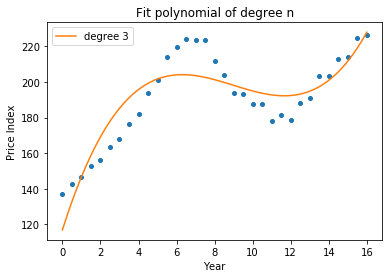

In [54]:
def fit_degree_n(n, x_vec, b_vec):
    # a degree n polynomial should have the form [a_n, a_{n-1}, ..., a_1, a_0].T * [x^n, ,,,, x, 1]
    # create a vandermonde matrix 
    A = np.vander(x_vec, n+1)
    coeff = la.lstsq(A, b_vec)[0]
    
    #regression polynomial
    my_poly = np.poly1d(coeff)
    
    #plot true values
    plt.plot(x_vec, b_vec, "o", markersize = 4)
    plt.xlabel("Year")
    plt.ylabel("Price Index")
    plt.title("Fit polynomial of degree n")
    
    #plot estimated values
    x_start = x_vec.min()
    x_end = x_vec.max()
    my_label = "degree " +str(n)
    plt.plot(np.linspace(x_start, x_end, 100), my_poly(np.linspace(x_start, x_end, 100)), label = my_label)
    plt.legend()
    
    #check with polyfit
    pf = np.polyfit(x_vec, b_vec, n)
    print("Is the calculated result the same from np.polyfut? ", np.allclose(coeff, pf))
    
    plt.show()
    

data = np.load("housing.npy")
years = data[:, 0]
prices = data[:, 1]
#degree 3
fit_degree_n(3, years, prices)

    

Is the calculated result the same from np.polyfut?  True


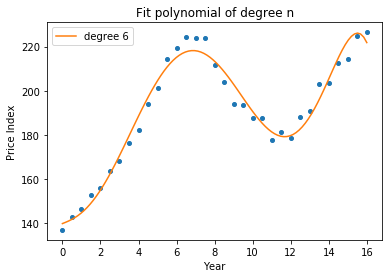

In [55]:
#degree 6
fit_degree_n(6, years, prices)

Is the calculated result the same from np.polyfut?  True


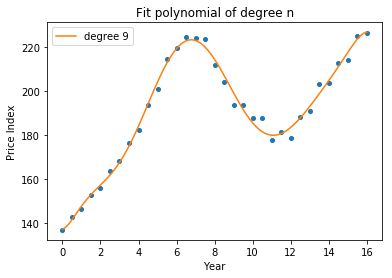

In [56]:
#degree 9
fit_degree_n(9, years, prices)

Is the calculated result the same from np.polyfut?  False


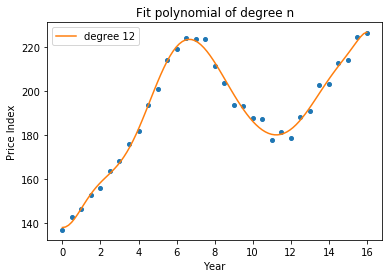

In [57]:
#degree 12
fit_degree_n(12, years, prices)

Problem 4

Observe that the standard  equation of an ellipse is $$\frac{x^2}{a^2} + \frac{y^2}{b^2} = 1.$$ Let $m=\frac{1}{a^2}, n=\frac{1}{b^2}.$ It follows that $$mx^2 + ny^2 = 1.$$ This is a linear system in $m$ and $n$.
To plot the ellipse, we simply let $x=a\cos(\theta), y=b\sin(\theta)$.

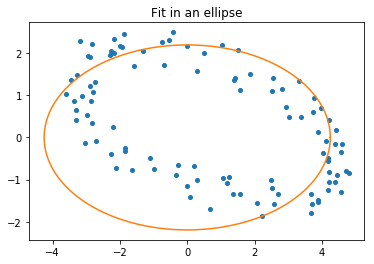

In [58]:
ellipse = np.load("ellipse.npy")
#print(ellipse)
x_vec = ellipse[:, 0]
y_vec = ellipse[:, 1]

def drawAnFittedellipse(x_vec, y_vec):
   #create a linear systems
    x2_vec = x_vec **2
    y2_vec = y_vec **2
    #RHS is a columns of ones
    b_vec = np.ones_like(x_vec)
    A = np.column_stack((x2_vec, y2_vec))
    coeff = la.lstsq(A, b_vec)[0]
    a = np.sqrt(1.0 / coeff[0])
    b = np.sqrt(1.0 / coeff[1])
    
    #plot
    plt.plot(x_vec, y_vec, "o", markersize = 4)
    theta_grid = np.linspace(0, 2*np.pi, 360)
    plt.plot(a*np.cos(theta_grid), b*(np.sin(theta_grid)))
    plt.title("Fit in an ellipse")
    plt.show()
drawAnFittedellipse(x_vec, y_vec)

In [59]:
def powerMethod(A, maxItr, tol):
    print("_______")
    m, n = A.shape
    x_0 = np.random.rand(n) + np.ones(n) # make it larger to avoid rounding error
    x_0 = x_0 / la.norm(x_0)
    currentItr = 0
    diff = 10
    
    while (currentItr<maxItr) or (diff > tol):
        x_prime = np.matmul(A, x_0)
        x_prime = x_prime / la.norm(x_prime)
        diff = la.norm(x_prime - x_0)
        x_0 = x_prime
        currentItr += 1
    eigval = np.dot(x_0, np.matmul(A, x_0))
    eigvec = x_0
    return eigval, eigvec

A = (np.random.random((10,10)) ) # make it larger to avoid rounding error
eigs, vec = la.eig(A)
loc = np.argmax(eigs)
lamb , x = eigs[loc], vec[loc]
my_lamb, my_x = powerMethod(A, 10000, 1e-16)
print("Does the eigvalue converge to true eigvalue?")
print(np.allclose(lamb, my_lamb))
print("Does the corresponding eigenvector satisfy Ax = lambda x?")
print(np.allclose(np.abs(my_lamb * my_x), np.abs(np.dot(A, my_x))))

    

_______
Does the eigvalue converge to true eigvalue?
True
Does the corresponding eigenvector satisfy Ax = lambda x?
True


Problem 6 

In [61]:
def QRfindeig(A, N, tol):
    m, n = A.shape
    
    S, temp = la.hessenberg(A, calc_q = True)
    
   
    for k in range(N):
        Q, R = la.qr(S)
        S = np.matmul(R, Q)
    eigs = []
    
    i = 0
    while i < n:
        #if Si is 1*!
        if (i == (n-1)) or (abs(S[i+1,i])<tol):
            eigs.append(S[i,i])
        else:
            #Si is 2*2
            a = S[i,i]
            b = S[i,i+1]
            c = S[i+1, i]
            d = S[i+1, i+1]
            lamba_1 = 0.5 * (a + d + cmath.sqrt((a+d)**2 - 4*(a*d-b*c)))
            lamba_2 = 0.5 * (a + d - cmath.sqrt((a+d)**2 - 4*(a*d-b*c)))
            eigs.append(lambda_1)
            eigs.append(lambda_2)
            i += 1
        i += 1
    return eigs
            
#Construct a random symmetric matrix
A = np.random.random((5,5))
A = A + A.T
my_evals = QRfindeig(A, 1000, 1e-8)
my_evals.sort()
print("Calculation: ", my_evals)
evals, evecs = la.eig(A)
evals.sort()
print("True values: ", evals)
print("It can be seen that they are approximately the same.")

Calculation:  [-0.5849068946624978, -0.031808538631748165, 0.39059948762214014, 1.1154873315272977, 5.825087210040732]
True values:  [-0.58490689+0.j -0.03180854+0.j  0.39059949+0.j  1.11548733+0.j
  5.82508721+0.j]
It can be seen that they are approximately the same.


Note that in the above code, we directly apply quadratic formula to calculate the eigenvalues of a 2*2 matrix.
We have the following:
$$(a-\lambda)(d-\lambda) - bc = 0 $$
$$\lambda^2 - (a+d)\lambda +(ad-bc) = 0$$
$$\lambda_1 = \frac{1}{2}[(a+d) + \sqrt{(a+d)^2 - 4(ad-bc)}] \text{ and } \lambda_2 = \frac{1}{2}[(a+d) - \sqrt{(a+d)^2 - 4(ad-bc)]}$$